<h2>🎯 FreshCart Churn Prediction - Baseline Model</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Final Project
    </b>
</h4>

<h4>
    📋 Notebook Contents
</h4>

<h5>
    <ol>
        <li>Data Preparation and Feature Creation</li>
        <li>Train-Test Split</li>
        <li>Baseline Model: Logistic Regression</li>
        <li>Baseline Model: Random Forest</li>
        <li>Model Evaluation</li>
        <li>Baseline Results and Next Steps</li>
    </ol>
</h5>

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import joblib

In [2]:
# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import create_rfm_features_pipeline
from features.behavioral_features import create_behavioral_features_pipeline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<h4>
    1️⃣ Data Preparation and Feature Creation
</h4>

In [5]:
# Load data
print("📦 Loading Instacart data...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

orders_df = data['orders']
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)
products_df = data['products']

print(f"✅ Data loaded:")
print(f"   Orders: {len(orders_df):,}")
print(f"   Order-Products: {len(order_products):,}")
print(f"   Products: {len(products_df):,}")

INFO:data.data_loader:📦 Loading Instacart datasets...
INFO:data.data_loader:   Loading orders.csv...


📦 Loading Instacart data...


INFO:data.data_loader:   ✅ Loaded orders: (3421083, 7)
INFO:data.data_loader:   Loading order_products__prior.csv...
INFO:data.data_loader:   ✅ Loaded order_products_prior: (32434489, 4)
INFO:data.data_loader:   Loading order_products__train.csv...
INFO:data.data_loader:   ✅ Loaded order_products_train: (1384617, 4)
INFO:data.data_loader:   Loading products.csv...
INFO:data.data_loader:   ✅ Loaded products: (49688, 4)
INFO:data.data_loader:   Loading aisles.csv...
INFO:data.data_loader:   ✅ Loaded aisles: (134, 2)
INFO:data.data_loader:   Loading departments.csv...
INFO:data.data_loader:   ✅ Loaded departments: (21, 2)
INFO:data.data_loader:✅ All datasets loaded successfully!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:DATA SUMMARY
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 rows x   7 co

✅ Data loaded:
   Orders: 3,421,083
   Order-Products: 33,819,106
   Products: 49,688


In [6]:
# --- HÜCRE 6 DÜZELTME: VERİ BÖLME VE ETİKETLEME ---

print("\n✂️  Splitting data into History (Features) and Future (Target)...")

# 1. Her kullanıcının SON siparişini belirle (Bu bizim HEDEF/TARGET verimiz)
last_orders = orders_df.groupby('user_id').tail(1)

# 2. Geri kalan tüm siparişler GEÇMİŞ/HISTORY verisidir (Feature'lar buradan türetilecek)
orders_history = orders_df.drop(last_orders.index)

# 3. Ürün detaylarını da sadece geçmiş siparişlere göre filtrele
# (Gelecekte sepette ne olduğunu bilirsek kopya çekmiş oluruz)
order_products_history = order_products[order_products['order_id'].isin(orders_history['order_id'])]

print(f"Total Orders: {len(orders_df):,}")
print(f"History Orders (Feature Source): {len(orders_history):,}")
print(f"Target Orders (Label Source): {len(last_orders):,}")

# --- HEDEF DEĞİŞKEN (LABEL) OLUŞTURMA ---

print("\n🏷️  Creating labels from Target Orders...")

# Instacart verisinde tarih yok, 'days_since_prior_order' var.
# Eğer son sipariş, bir öncekinden 30 gün (veya daha fazla) sonra verildiyse
# bu müşteri o aralıkta "Churn" (Kaybedilmiş) durumuna düşmüştür.

labels_df = last_orders[['user_id', 'days_since_prior_order']].copy()

# Churn Tanımı: 30+ gün sipariş vermeyenler (1), verenler (0)
labels_df['is_churn'] = (labels_df['days_since_prior_order'] >= 30).astype(int)

print(f"✅ Churn Labels Created:")
print(f"   Total users: {len(labels_df):,}")
print(f"   Churn Rate: {labels_df['is_churn'].mean():.2%}")
print(labels_df['is_churn'].value_counts())


✂️  Splitting data into History (Features) and Future (Target)...
Total Orders: 3,421,083
History Orders (Feature Source): 3,214,874
Target Orders (Label Source): 206,209

🏷️  Creating labels from Target Orders...
✅ Churn Labels Created:
   Total users: 206,209
   Churn Rate: 30.64%
is_churn
0    143023
1     63186
Name: count, dtype: int64


In [7]:
# Önceki diyaloglarda paylaştığın 'features/rfm_features.py' dosyasındaki sınıfı kullanalım.
# Eğer import hatası alırsan, sınıfı direkt buraya yapıştırabilirsin veya doğru importu kullanmalısın.
# Dosya adın 'rfm_features.py' ise içindeki sınıf 'RFMFeatureEngineer' olmalı.

from features.rfm_features import RFMFeatureEngineer
from features.behavioral_features import BehavioralFeatureEngineer

print("\n🔧 Creating Features from HISTORY data (No Leakage)...")

# 1. RFM Features
rfm_engineer = RFMFeatureEngineer()
rfm_features = rfm_engineer.create_all_rfm_features(orders_history, order_products_history)

# 2. Behavioral Features
behavioral_engineer = BehavioralFeatureEngineer()
behavioral_features = behavioral_engineer.create_all_behavioral_features(
    orders_history, order_products_history, products_df
)

# 3. Merge Everything
print("\n🔗 Merging features...")
master_df = labels_df[['user_id', 'is_churn']].merge(rfm_features, on='user_id', how='left')
master_df = master_df.merge(behavioral_features, on='user_id', how='left')

# Eksik verileri doldur (Yeni kullanıcılar vs.)
master_df = master_df.fillna(0)

print(f"✅ Final Dataset Shape: {master_df.shape}")
# Leakage kontrolü: 'days_since_last_order' feature'ı, ARTIK son siparişin değil,
# ondan önceki siparişin tarihine göre hesaplandı. Yani hedefi görmüyor!

INFO:features.rfm_features:🔧 Creating RFM features...
INFO:features.rfm_features:   Creating recency features...



🔧 Creating Features from HISTORY data (No Leakage)...


INFO:features.rfm_features:   Creating frequency features...
INFO:features.rfm_features:   Creating monetary features (using basket size as a proxy)...
INFO:features.rfm_features:✅ Created 14 RFM features
INFO:features.rfm_features:   Features: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']
INFO:features.behavioral_features:🧠 Creating behavioral features...
INFO:features.behavioral_features:   Creating time-based features...
INFO:features.behavioral_features:   Creating reorder behavior features...
INFO:features.behavioral_features:   Creating diversity features...
INFO:features.behavioral_features:✅ Created 22 behavioral features



🔗 Merging features...
✅ Final Dataset Shape: (206209, 38)


In [8]:
# Display sample
print("\n📊 Sample Data:")
display(master_df.head(10))

print("\n📈 Feature Statistics:")
display(master_df.describe())


📊 Sample Data:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,total_unique_products_ordered,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
0,1,0,623,686,63,19.555556,10,0.156250,0.457084,9.395625,5.900000,59,1.523884,0.220853,5.900000,59,10.300000,3.591657,7,2.500000,1.269296,1,0.000000,0.000000,0.600000,0.400000,0.694915,41,0.464396,0.705833,0.317544,4.0,18,12,7,5.900000,0.300000,0.500000
1,2,1,595,686,91,15.230769,14,0.152174,0.607923,9.867065,13.928571,195,5.717238,0.382973,13.928571,195,10.571429,1.554858,10,2.142857,1.231456,1,0.071429,0.000000,0.857143,0.142857,0.476923,93,0.500753,0.447961,0.315789,9.0,102,33,13,13.928571,0.520408,0.661017
2,3,0,609,686,77,12.090909,12,0.153846,0.410592,5.375026,7.333333,88,2.103388,0.252407,7.333333,88,16.416667,1.443376,16,1.083333,1.311372,0,0.000000,0.000000,0.000000,0.750000,0.625000,55,0.486897,0.658817,0.333725,5.0,33,16,9,7.333333,0.370787,0.277778
3,4,1,658,686,28,13.750000,5,0.172414,0.644068,9.500000,3.600000,18,2.073644,0.450792,3.600000,18,12.600000,1.673320,11,4.800000,0.836660,4,0.600000,0.000000,0.400000,0.600000,0.055556,1,0.235702,0.028571,0.063888,0.0,17,14,9,3.600000,0.894737,1.000000
4,5,0,665,686,21,13.333333,4,0.181818,0.344155,4.932883,9.250000,37,3.095696,0.302019,9.250000,37,16.000000,2.828427,18,1.750000,1.500000,3,0.000000,0.000000,0.000000,0.500000,0.378378,14,0.491672,0.377778,0.277555,0.0,23,16,9,9.250000,0.605263,0.500000
5,6,0,672,686,14,9.000000,3,0.200000,0.424264,4.242641,4.666667,14,2.081666,0.367353,4.666667,14,17.333333,1.154701,18,3.666667,1.527525,2,0.333333,0.000000,0.000000,0.333333,0.142857,2,0.363137,0.095238,0.164957,0.0,12,8,5,4.666667,0.800000,1.000000
6,7,0,553,686,133,10.684211,20,0.149254,0.767122,8.963213,10.300000,206,5.894690,0.521654,10.300000,206,13.600000,3.830625,9,1.850000,1.871532,0,0.150000,0.050000,0.300000,0.450000,0.669903,138,0.471393,0.754255,0.323768,13.0,68,34,12,10.300000,0.328502,0.568627
7,8,0,672,686,14,30.000000,3,0.200000,0.000000,0.000000,16.333333,49,4.163332,0.240192,16.333333,49,2.666667,4.618802,0,4.000000,2.645751,1,0.666667,0.666667,0.333333,0.000000,0.265306,13,0.446071,0.305983,0.275224,0.0,36,16,6,16.333333,0.720000,0.615385
8,9,1,672,686,14,18.000000,3,0.200000,0.893188,16.970563,25.333333,76,12.662280,0.480846,25.333333,76,14.333333,2.516611,12,2.000000,2.645751,0,0.333333,0.000000,0.000000,1.000000,0.236842,18,0.427970,0.254545,0.221191,0.0,58,26,13,25.333333,0.753247,0.600000
9,10,1,658,686,28,19.750000,5,0.172414,0.402008,8.341663,28.600000,143,14.842507,0.501436,28.600000,143,16.600000,2.701851,15,3.600000,1.341641,3,0.400000,0.200000,0.000000,0.600000,0.342657,49,0.476266,0.325665,0.413018,0.0,94,26,9,28.600000,0.652778,0.566667



📈 Feature Statistics:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,total_unique_products_ordered,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
count,206209.000000,206209.000000,206209.000000,206209.0,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.00000,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,0.306417,583.867431,686.0,102.132569,15.209435,15.590367,0.163196,0.514670,7.397716,9.951586,157.289396,4.266349,0.400273,9.951586,157.289396,13.586213,3.588411,12.181559,2.753258,1.880159,2.077121,0.263415,0.102728,0.311936,0.485198,0.432249,92.753158,0.444387,0.457151,0.284327,7.332595,64.536238,27.78370,10.827796,9.951586,0.553921,0.570311
std,59527.555167,0.461006,116.583415,0.0,116.583415,7.105277,16.654774,0.017149,0.242831,3.746804,5.863570,204.208233,2.675061,0.167088,5.863570,204.208233,2.110461,1.553595,3.976492,0.941419,0.614210,2.060036,0.201648,0.151382,0.232377,0.233656,0.212144,158.400413,0.084416,0.215915,0.098324,12.433628,56.592339,16.11153,3.791768,5.863570,0.202130,0.216801
min,1.000000,0.000000,0.000000,686.0,14.000000,0.000000,3.000000,0.144105,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.010417,0.000000
25%,51553.000000,0.000000,560.000000,686.0,28.000000,9.416667,5.000000,0.149606,0.375000,4.730999,5.740741,39.000000,2.345208,0.288525,5.740741,39.000000,12.222222,2.548067,9.000000,2.200000,1.527525,0.000000,0.125000,0.000000,0.142857,0.333333,0.267857,10.000000,0.423915,0.294452,0.230136,0.000000,25.000000,15.00000,8.000000,5.740741,0.400000,0.454545
50%,103105.000000,0.000000,630.000000,686.0,56.000000,14.500000,9.000000,0.157895,0.527588,7.767830,8.933333,83.000000,3.781534,0.383990,8.933333,83.000000,13.571429,3.438246,12.000000,2.750000,1.936492,1.000000,0.250000,0.019608,0.285714,0.500000,0.428571,33.000000,0.474743,0.463889,0.282146,2.000000,48.000000,25.00000,11.000000,8.933333,0.558824,0.588235
75%,154657.000000,1.000000,658.000000,686.0,126.000000,20.285714,19.000000,0.172414,0.663707,9.908470,13.000000,188.000000,5.609516,0.490988,13.000000,188.000000,15.000000,4.438066,15.000000,3.333333,2.274152,4.000000,0.366667,0.166667,0.454545,0.666667,0.595745,101.000000,0.496842,0.626410,0.340386,9.000000,86.000000,38.00000,14.000000,13.000000,0.714286,0.714286
max,206209.000000,1.000000,672.000000,686.0,686.000000,30.000000,99.000000,0.200000,2.282372,21.213203,70.250000,3725.000000,44.747439,1.728671,70.250000,3725.000000,23.000000,13.279056,23.000000,6.000000,3.464102,6.000000,1.000000,1.000000,1.000000,1.000000,0.989529,3275.000000,0.577350,0.989899,0.577350,184.000000,726.000000,102.00000,21.000000,70.250000,0.989130,1.000000


In [9]:
# Prepare X and y
X = master_df.drop(['user_id', 'is_churn'], axis=1)
y = master_df['is_churn']

feature_names = X.columns.tolist()

print(f"📊 Dataset prepared:")
print(f"   Features (X): {X.shape}")
print(f"   Labels (y): {y.shape}")
print(f"   Feature count: {len(feature_names)}")

📊 Dataset prepared:
   Features (X): (206209, 36)
   Labels (y): (206209,)
   Feature count: 36


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\n✅ Train-Test Split:")
print(f"   Train: {X_train.shape} - Churn rate: {y_train.mean():.2%}")
print(f"   Test:  {X_test.shape} - Churn rate: {y_test.mean():.2%}")


✅ Train-Test Split:
   Train: (164967, 36) - Churn rate: 30.64%
   Test:  (41242, 36) - Churn rate: 30.64%


In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, MODEL_DIR / 'baseline_scaler.pkl')
print("✅ Scaler fitted and saved")

✅ Scaler fitted and saved


<h2>
    3️⃣ Baseline Model 1: Logistic Regression
</h2>

In [12]:
print("\n" + "="*80)
print("BASELINE MODEL 1: LOGISTIC REGRESSION")
print("="*80)

# Train model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

print("\n📊 Logistic Regression Results:")
print(f"   Accuracy:  {lr_metrics['accuracy']:.4f}")
print(f"   Precision: {lr_metrics['precision']:.4f}")
print(f"   Recall:    {lr_metrics['recall']:.4f}")
print(f"   F1-Score:  {lr_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {lr_metrics['roc_auc']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Churned']))

# Save model
joblib.dump(lr_model, MODEL_DIR / 'baseline_logistic_regression.pkl')
print("\n✅ Logistic Regression model saved")


BASELINE MODEL 1: LOGISTIC REGRESSION

📊 Logistic Regression Results:
   Accuracy:  0.6642
   Precision: 0.4695
   Recall:    0.7393
   F1-Score:  0.5743
   ROC-AUC:   0.7475

📋 Classification Report:
              precision    recall  f1-score   support

      Active       0.85      0.63      0.72     28605
     Churned       0.47      0.74      0.57     12637

    accuracy                           0.66     41242
   macro avg       0.66      0.69      0.65     41242
weighted avg       0.73      0.66      0.68     41242


✅ Logistic Regression model saved


<h2>
    4️⃣ Baseline Model 2: Random Forest
</h2>

In [13]:
print("\n" + "="*80)
print("BASELINE MODEL 2: RANDOM FOREST")
print("="*80)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # RF doesn't require scaling

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrics
rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

print("\n📊 Random Forest Results:")
print(f"   Accuracy:  {rf_metrics['accuracy']:.4f}")
print(f"   Precision: {rf_metrics['precision']:.4f}")
print(f"   Recall:    {rf_metrics['recall']:.4f}")
print(f"   F1-Score:  {rf_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {rf_metrics['roc_auc']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Churned']))

# Save model
joblib.dump(rf_model, MODEL_DIR / 'baseline_random_forest.pkl')
print("\n✅ Random Forest model saved")


BASELINE MODEL 2: RANDOM FOREST

📊 Random Forest Results:
   Accuracy:  0.6623
   Precision: 0.4687
   Recall:    0.7645
   F1-Score:  0.5811
   ROC-AUC:   0.7535

📋 Classification Report:
              precision    recall  f1-score   support

      Active       0.86      0.62      0.72     28605
     Churned       0.47      0.76      0.58     12637

    accuracy                           0.66     41242
   macro avg       0.66      0.69      0.65     41242
weighted avg       0.74      0.66      0.68     41242


✅ Random Forest model saved


<h2>
    5️⃣ Model Evaluation & Visualization
</h2>

In [14]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], rf_metrics['precision']],
    'Recall': [lr_metrics['recall'], rf_metrics['recall']],
    'F1-Score': [lr_metrics['f1'], rf_metrics['f1']],
    'ROC-AUC': [lr_metrics['roc_auc'], rf_metrics['roc_auc']]
})

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON")
print("="*80)
display(comparison_df)


BASELINE MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.664177,0.469521,0.739337,0.574318,0.747451
1,Random Forest,0.662335,0.468730,0.764501,0.581148,0.753535


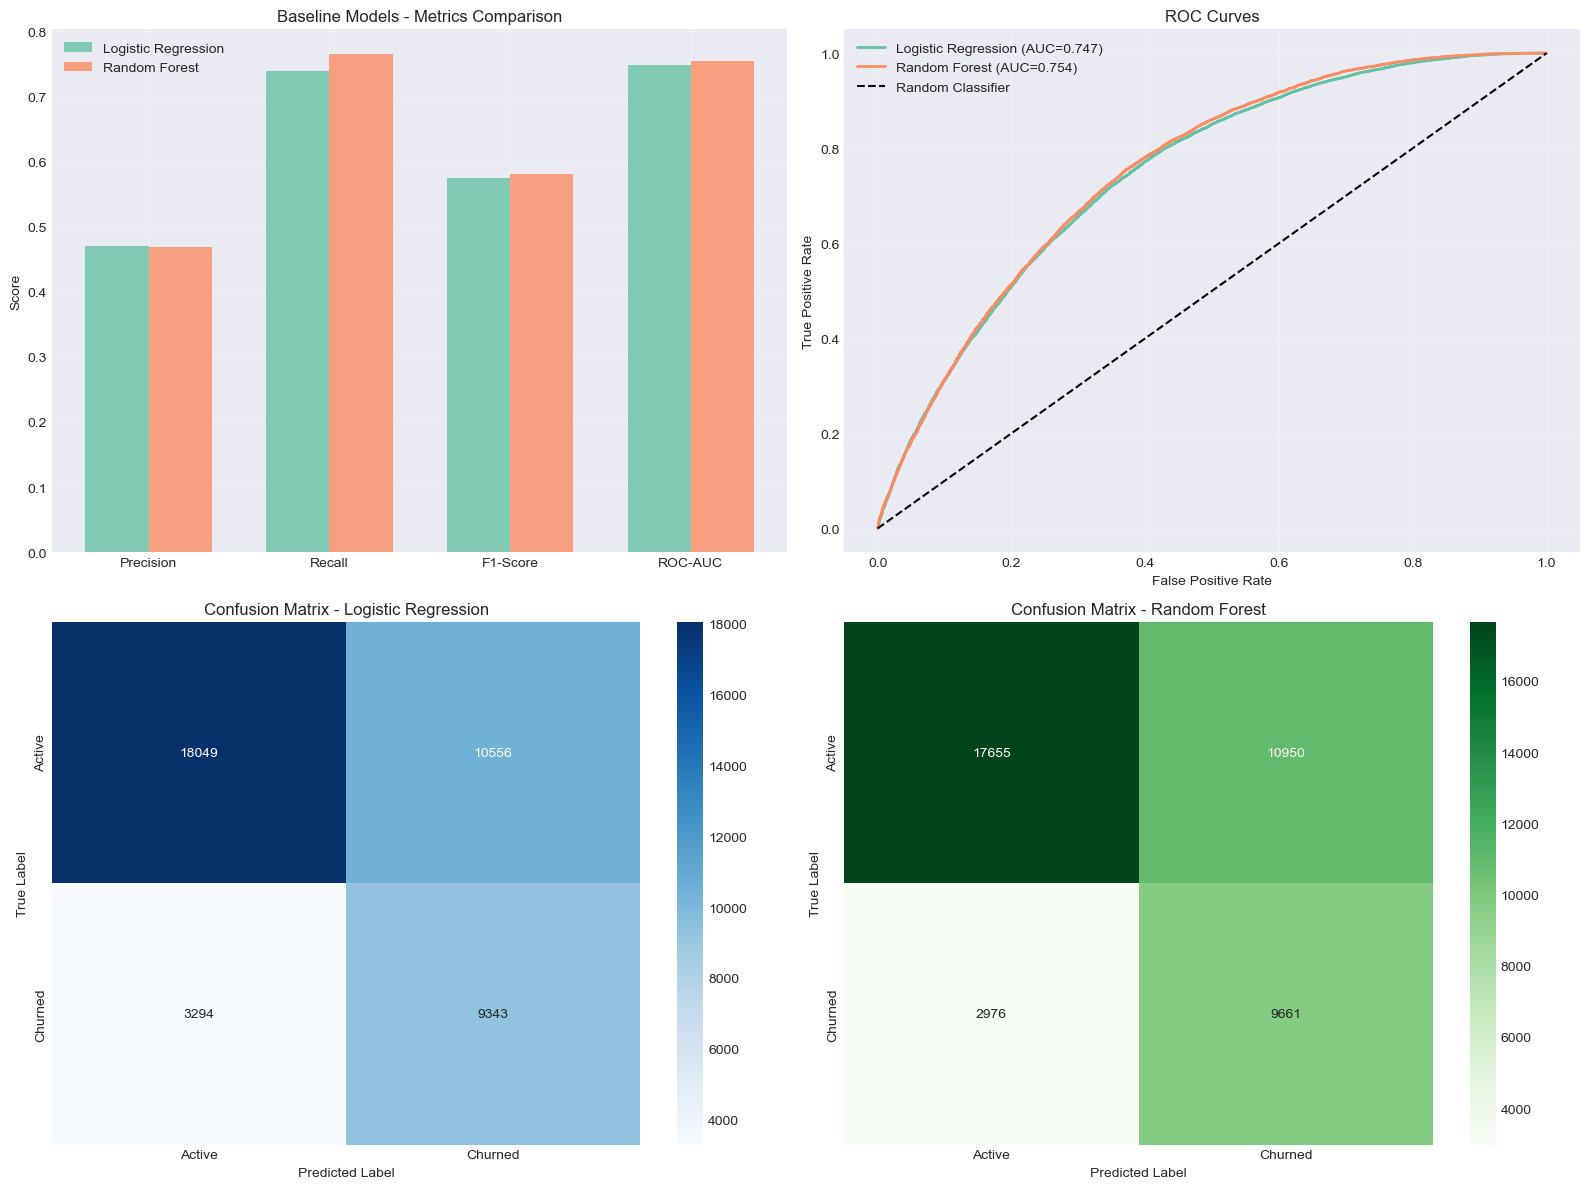

In [15]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison
ax = axes[0, 0]
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

lr_values = [lr_metrics['precision'], lr_metrics['recall'], lr_metrics['f1'], lr_metrics['roc_auc']]
rf_values = [rf_metrics['precision'], rf_metrics['recall'], rf_metrics['f1'], rf_metrics['roc_auc']]

ax.bar(x - width/2, lr_values, width, label='Logistic Regression', alpha=0.8)
ax.bar(x + width/2, rf_values, width, label='Random Forest', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Baseline Models - Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. ROC Curves
ax = axes[0, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix - Logistic Regression
ax = axes[1, 0]
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Logistic Regression')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Active', 'Churned'])
ax.set_yticklabels(['Active', 'Churned'])

# 4. Confusion Matrix - Random Forest
ax = axes[1, 1]
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Confusion Matrix - Random Forest')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Active', 'Churned'])
ax.set_yticklabels(['Active', 'Churned'])

plt.tight_layout()
plt.savefig('../plots/05_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


🔝 Top 20 Most Important Features (Random Forest):


,feature,importance
3,avg_days_between_orders,0.219118
0,days_since_last_order,0.121885
2,customer_age_days,0.090021
5,orders_per_day,0.086618
4,total_orders,0.063168
7,std_days_between_orders,0.055372
9,total_items_ordered,0.039488
13,total_unique_products_ordered,0.038409
25,total_reordered_items,0.038292
29,favorite_products_count,0.035032


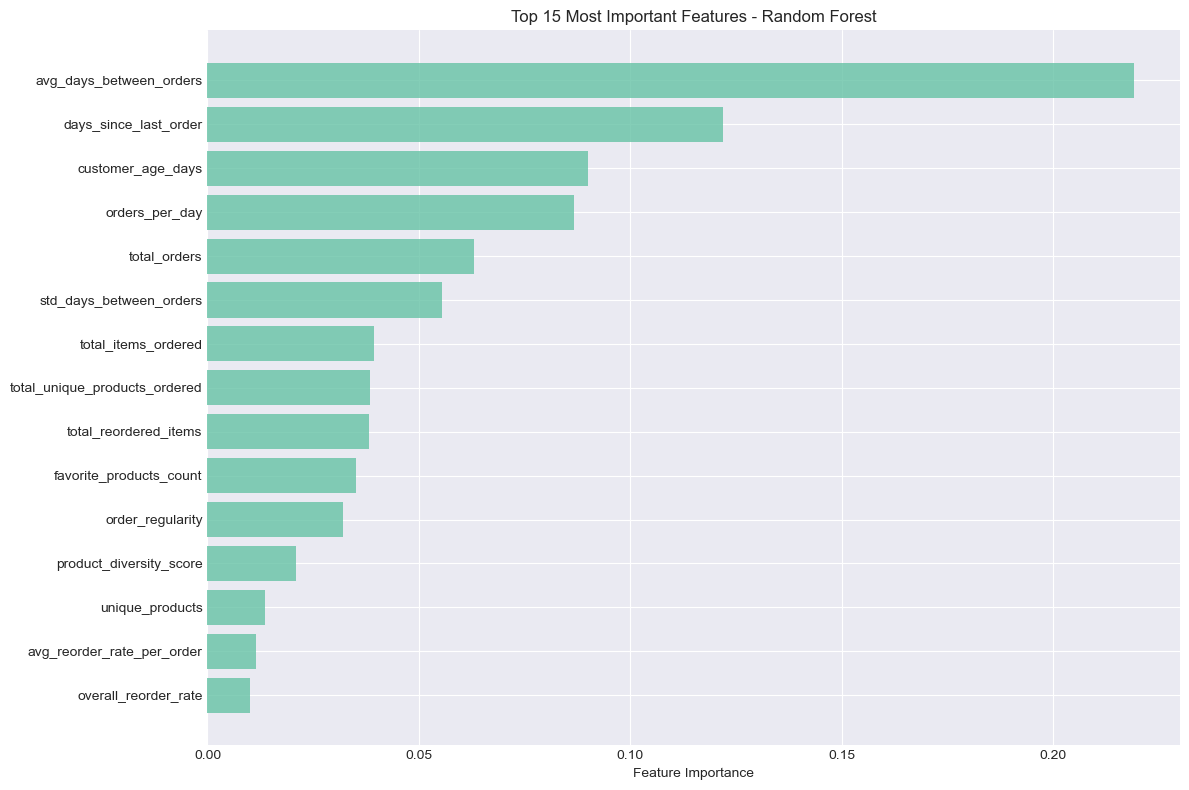

In [16]:
# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 20 Most Important Features (Random Forest):")
display(feature_importance.head(20))

# Visualize top 15
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/06_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    6️⃣ Baseline Results and Findings
</h2>

<h4>
    <b>📊 Model Performance</b>
</h4>

<h5>
    <b>Logistic Regression:</b>
</h5>
<ul>
    <li>Simple and interpretable model</li>
    <li>Fast training</li>
    <li>Reasonable performance but lower than RF</li>
</ul>

<h4>
    <b>🎯 Key Findings</b>
</h4>

<h5>
    <b>Most Important Features:</b>
</h5>
<ol>
    <li>`days_since_last_order` - The most critical feature!</li>
    <li>`total_orders` - Customer history is important</li>
    <li>`overall_reorder_rate` - An indicator of loyalty</li>
    <li>`avg_basket_size` - Engagement level</li>
    <li>`customer_age_days` - Customer tenure</li>
</ol>

<h4>
    <b>🚀 Next Steps</b>
</h4>

<ol>
    <li>
        ✅ <b>Feature Engineering</b>
        <ul>
            <li>Add RFM scores</li>
            <li>Interaction features</li>
            <li>Polynomial features</li>
            <li>Time-series features</li>
        </ul>
    </li>
    <li>
        ✅ <b>Advanced Models</b>
        <ul>
            <li>LightGBM</li>
            <li>XGBoost</li>
            <li>CatBoost</li>
            <li>Ensemble methods</li>
        </ul>
    </li>
    <li>
        ✅ <b>Hyperparameter Tuning</b>
        <ul>
            <li>Use Optuna</li>
            <li>Cross-validation</li>
            <li>Feature selection</li>
        </ul>
    </li>
    <li>
        ✅ <b>Model Interpretation</b>
        <ul>
            <li>SHAP values</li>
            <li>Partial dependence plots</li>
            <li>Business insights</li>
        </ul>
    </li>
</ol>

<p>
    <b>To continue:</b> Proceed to the <code>03_feature_engineering.ipynb</code> notebook! 🚀
</p>

In [17]:
# Save baseline results
baseline_results = {
    'logistic_regression': lr_metrics,
    'random_forest': rf_metrics,
    'feature_importance': feature_importance.to_dict(),
    'comparison': comparison_df.to_dict()
}

import json
with open('../docs/baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=4)

print("\n✅ Baseline results saved to docs/baseline_results.json")
print("\n🎉 Baseline modeling complete! Ready for advanced models.")


✅ Baseline results saved to docs/baseline_results.json

🎉 Baseline modeling complete! Ready for advanced models.
